In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pybedtools
from tqdm import tqdm 
import numpy as np 
import anndata
import scanpy as sc 

In [4]:
BASE_DIR = "/ssd/users/cfx"
chip_data_dir = f"{BASE_DIR}/data/ENCODE_ChIP"
rna_data_dir = f"{BASE_DIR}/data/ENCODE_Bulk_RNA"
Target_dir = f"./data"

## preprocess RNA data

In [3]:
rna_meta = pd.read_csv(f"{rna_data_dir}/gene_quantifications_meta.csv", index_col=0)
rna_meta[:5]

,term_name,classification,name,simple_biosample_summary,SD of log ratios,Pearson correlation,Spearman correlation,MAD of log ratios,number_of_genes_detected,accession,assay_title,experiment
ENCFF997PHW,endothelial cell of umbilical vein,primary cell,primary_cell_CL_0002618,newborn,0.588,0.965985,0.968487,0.473,12634.0,ENCFF997PHW,polyA plus RNA-seq,ENCSR654UPQ
ENCFF343HHX,"CD8-positive, alpha-beta T cell",primary cell,primary_cell_CL_0000625,male adult (37 years),NaN,NaN,NaN,NaN,15680.0,ENCFF343HHX,polyA plus RNA-seq,ENCSR861QKF
ENCFF813SDK,muscle of leg,tissue,tissue_UBERON_0001383,male embryo (101 days),NaN,NaN,NaN,NaN,16958.0,ENCFF813SDK,polyA plus RNA-seq,ENCSR447IJE
ENCFF624FHC,dorsolateral prefrontal cortex,tissue,tissue_UBERON_0009834,female adult (81 years) with Cognitive impairment,NaN,NaN,NaN,NaN,16872.0,ENCFF624FHC,total RNA-seq,ENCSR777KAR
ENCFF513IPT,GM12878,cell line,cell_line_EFO_0002784,NaN,0.546,0.967598,0.968269,0.384,13227.0,ENCFF513IPT,polyA plus RNA-seq,ENCSR000EYN


In [4]:
tpms = pd.read_csv(f"{rna_data_dir}/tpms.csv", index_col=0)
tpms[:5]

,ENCFF997PHW,ENCFF343HHX,ENCFF813SDK,ENCFF624FHC,ENCFF513IPT,ENCFF780XPP,ENCFF762VOE,ENCFF710YES,ENCFF566ZGR,ENCFF495AYZ,...,ENCFF201RLT,ENCFF472HFI,ENCFF367CLO,ENCFF617KGY,ENCFF545DTG,ENCFF422LVI,ENCFF766VIZ,ENCFF795IDG,ENCFF170TKR,ENCFF664LYH
ENSG00000000003.14,32.69,0.62,25.13,2.86,0.06,2.41,2.11,3.60,7.48,1.05,...,4.14,0.00,0.00,1.82,2.25,23.46,8.20,0.25,0.03,0.00
ENSG00000000005.5,0.00,0.20,291.94,0.00,0.00,0.00,0.00,0.00,0.00,0.02,...,0.04,0.00,0.00,0.00,0.00,74.01,0.72,0.03,0.00,0.00
ENSG00000000419.12,49.82,24.79,33.73,7.78,37.62,1.79,8.56,5.36,91.68,1.40,...,6.56,134.90,79.57,0.90,8.61,36.84,15.79,0.55,23.85,36.93
ENSG00000000457.13,1.58,15.17,6.13,2.71,6.69,0.38,2.35,1.73,11.97,0.52,...,2.97,2.57,2.35,0.35,0.70,9.29,7.05,0.22,6.44,2.19
ENSG00000000460.16,9.35,4.44,5.13,2.67,8.75,0.16,1.59,0.32,3.76,0.32,...,1.87,40.20,11.73,0.19,0.42,6.99,2.19,0.08,3.21,13.40


1969.0 22461.0


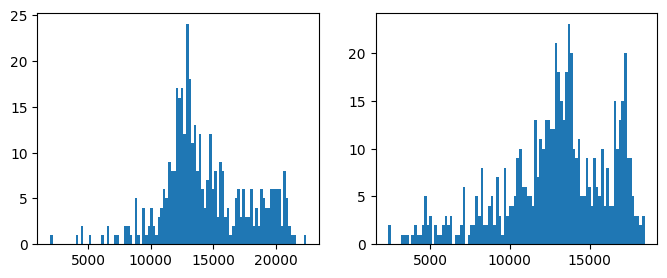

In [5]:
fig, ax = plt.subplots(1,2,figsize=(8, 3))
ax[0].hist(rna_meta[rna_meta['assay_title']=="polyA plus RNA-seq"]['number_of_genes_detected'], bins=100);
ax[1].hist(rna_meta[rna_meta['assay_title']=="total RNA-seq"]['number_of_genes_detected'], bins=100);

print(rna_meta['number_of_genes_detected'].min(), rna_meta['number_of_genes_detected'].max())

In [6]:
## intersect ChIP samples 
chip_meta = pd.read_csv(f"{chip_data_dir}/ENCODE4_TF_ChIPseq_bed_list.tsv", delimiter="\t")
chip_meta[:5]

,Accession,Target of assay,Biosample term name,Biosample classification,Assay title,bed narrowPeak,process version
0,ENCSR577YCO,ARHGAP35,HepG2,cell line,TF ChIP-seq,ENCFF639APT,ENCODE4 v1.9.0 GRCh38
1,ENCSR924LSO,E2F4,HepG2,cell line,TF ChIP-seq,ENCFF245XOL,ENCODE4 v1.4.0 GRCh38
2,ENCSR724YTA,CTCF,dorsolateral prefrontal cortex,tissue,TF ChIP-seq,ENCFF141KSG,ENCODE4 v1.8.0 GRCh38
3,ENCSR423ZUM,CTCF,dorsolateral prefrontal cortex,tissue,TF ChIP-seq,ENCFF822EDI,ENCODE4 v1.8.0 GRCh38
4,ENCSR763FNU,CGGBP1,K562,cell line,TF ChIP-seq,ENCFF771XZZ,ENCODE4 v1.9.0 GRCh38


In [7]:
tissue_rna = list(set(rna_meta['term_name']))
print(len(tissue_rna))
tissues_chip = list(set(chip_meta['Biosample term name']))
print(len(tissues_chip))

280
177


In [8]:
tissue_overlap = pd.Index(chip_meta['Biosample term name']).intersection(rna_meta['term_name'])
tissue_overlap

Index(['HepG2', 'dorsolateral prefrontal cortex', 'K562', 'pancreas',
       'SK-N-SH', 'WTC11', 'spleen', 'adrenal gland', 'A549',
       'heart right ventricle',
       ...
       'osteocyte', 'subcutaneous adipose tissue', 'smooth muscle cell',
       'endothelial cell', 'mesothelial cell of epicardium',
       'type B pancreatic cell', 'endodermal cell', 'H9',
       'progenitor cell of endocrine pancreas', 'activated B cell'],
      dtype='object', name='Biosample term name', length=111)

In [9]:
for i, tissue in enumerate(tissue_overlap):
    chip_sub = chip_meta[chip_meta['Biosample term name']==tissue]
    rna_sub = rna_meta[rna_meta['term_name']==tissue]
    print(tissue, len(chip_sub), len(rna_sub))

HepG2 625 17
dorsolateral prefrontal cortex 59 120
K562 515 34
pancreas 5 9
SK-N-SH 55 4
WTC11 82 8
spleen 13 14
adrenal gland 6 16
A549 59 15
heart right ventricle 11 12
heart left ventricle 14 11
neural progenitor cell 2 1
left ventricle myocardium inferior 1 1
body of pancreas 7 2
GM12878 138 19
uterus 4 4
upper lobe of left lung 11 6
thyroid gland 7 5
tibial nerve 8 4
stomach 8 15
gastroesophageal sphincter 8 4
B cell 2 3
IMR-90 12 6
mucosa of descending colon 1 3
HeLa-S3 47 5
fibroblast of the aortic adventitia 1 1
H1 46 12
MCF-7 106 5
fibroblast of villous mesenchyme 1 1
fibroblast of dermis 1 1
GM23338 12 3
keratinocyte 3 5
placenta 2 13
HCT116 19 2
Caco-2 2 1
AG04450 1 1
GM12892 2 1
Panc1 5 2
mammary epithelial cell 2 4
neural cell 4 1
kidney 1 6
lung 1 5
PFSK-1 3 1
liver 30 5
PC-9 1 1
bronchial epithelial cell 1 1
endothelial cell of umbilical vein 8 6
GM12891 3 1
fibroblast of lung 3 3
BE2C 1 1
epithelial cell of proximal tubule 1 1
osteoblast 1 1
foreskin fibroblast 2 2
pros

In [10]:
tpm_dir = f"{BASE_DIR}/data/ENCODE_Bulk_RNA"
tpms = pd.read_csv(f"{rna_data_dir}/tpms.csv", index_col=0)
## subset to rnas in intersected tissue 
tpms = tpms.loc[:,rna_meta['accession']]
print(tpms.shape)
tpms = tpms.fillna(0)
tpms = tpms.loc[tpms.sum(axis=1)!=0,]       ## remove all 0 rows 
print(tpms.shape)
## map accession to tissues 
# col_rename_map = dict(zip(rna_meta['accession'], rna_meta['term_name']))
# col_rename_map = {k:f"{col_rename_map[k]}_{k}" for k in col_rename_map}
# tpms = tpms.rename(col_rename_map, axis=1)
tpms[:5]        

(92380, 1008)
(79402, 1008)


,ENCFF997PHW,ENCFF343HHX,ENCFF813SDK,ENCFF624FHC,ENCFF513IPT,ENCFF780XPP,ENCFF762VOE,ENCFF710YES,ENCFF566ZGR,ENCFF495AYZ,...,ENCFF201RLT,ENCFF472HFI,ENCFF367CLO,ENCFF617KGY,ENCFF545DTG,ENCFF422LVI,ENCFF766VIZ,ENCFF795IDG,ENCFF170TKR,ENCFF664LYH
ENSG00000000003.14,32.69,0.62,25.13,2.86,0.06,2.41,2.11,3.60,7.48,1.05,...,4.14,0.00,0.00,1.82,2.25,23.46,8.20,0.25,0.03,0.00
ENSG00000000005.5,0.00,0.20,291.94,0.00,0.00,0.00,0.00,0.00,0.00,0.02,...,0.04,0.00,0.00,0.00,0.00,74.01,0.72,0.03,0.00,0.00
ENSG00000000419.12,49.82,24.79,33.73,7.78,37.62,1.79,8.56,5.36,91.68,1.40,...,6.56,134.90,79.57,0.90,8.61,36.84,15.79,0.55,23.85,36.93
ENSG00000000457.13,1.58,15.17,6.13,2.71,6.69,0.38,2.35,1.73,11.97,0.52,...,2.97,2.57,2.35,0.35,0.70,9.29,7.05,0.22,6.44,2.19
ENSG00000000460.16,9.35,4.44,5.13,2.67,8.75,0.16,1.59,0.32,3.76,0.32,...,1.87,40.20,11.73,0.19,0.42,6.99,2.19,0.08,3.21,13.40


In [11]:
### group tpms of different geneid versions
tpms['ensembl'] = list(map(lambda x: x.split(".")[0], tpms.index))          ##remove & merge version number appended? see https://www.gencodegenes.org/pages/data_format.html
tpms_genes = tpms.groupby("ensembl").sum()
tpms_genes.shape

(59096, 1008)

In [12]:
ad_rna_bulk = anndata.AnnData(tpms_genes.T)
ad_rna_bulk.obs = rna_meta
ad_rna_bulk

AnnData object with n_obs × n_vars = 1008 × 59096
    obs: 'term_name', 'classification', 'name', 'simple_biosample_summary', 'SD of log ratios', 'Pearson correlation', 'Spearman correlation', 'MAD of log ratios', 'number_of_genes_detected', 'accession', 'assay_title', 'experiment'

In [13]:
## actually subset to overlapped tissues 
ad_rna_bulk = ad_rna_bulk[ad_rna_bulk.obs['term_name'].isin(tissue_overlap)]
ad_rna_bulk

View of AnnData object with n_obs × n_vars = 600 × 59096
    obs: 'term_name', 'classification', 'name', 'simple_biosample_summary', 'SD of log ratios', 'Pearson correlation', 'Spearman correlation', 'MAD of log ratios', 'number_of_genes_detected', 'accession', 'assay_title', 'experiment'

In [14]:
ad_rna_bulk.write_h5ad(f"{Target_dir}/ad_rna_bulk.h5ad")

/ssd/users/cfx/conda_envs/conda_envs/py3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/ssd/users/cfx/conda_envs/conda_envs/py3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/ssd/users/cfx/conda_envs/conda_envs/py3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/ssd/users/cfx/conda_envs/conda_envs/py3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/ssd/users/cfx/conda_envs/conda_envs/py3.11/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModification

## preprocess chip data

In [15]:
## subset chip to overlapped tissues 
print(chip_meta.shape)
chip_meta = chip_meta[chip_meta['Biosample term name'].isin(tissue_overlap)]
print(chip_meta.shape)

## remove CTCF , too many samples... 
chip_meta = chip_meta[chip_meta['Target of assay']!="CTCF"]

(2395, 7)
(2092, 7)


In [16]:
bed_dir = f"{chip_data_dir}/bedNarrow_process"
bed_files = chip_meta['bed narrowPeak'].dropna()
all_tfs = chip_meta['Target of assay'].unique()
print(len(all_tfs),len(bed_files))


780 1736


In [ ]:
## merge to a shared peak set 
all_peaks_merge = pybedtools.BedTool([])

for f in tqdm(bed_files):
    f_full = f"{bed_dir}/{f}.bed"
    aa = pybedtools.BedTool(f_full)
    all_peaks_merge = all_peaks_merge.cat(aa)           ## merge by default 

all_peaks_merge_df = pd.read_table(all_peaks_merge.fn, 
                                    names=['chrom', 'start', 'stop'])
all_peaks_merge_df.index = all_peaks_merge_df['chrom'] + ":" + all_peaks_merge_df['start'].astype(str) + "-" + all_peaks_merge_df['stop'].astype(str)


In [ ]:
## each sample's overlap with the merged peak set 
for f in tqdm(bed_files):               
    f_full = f"{bed_dir}/{f}.bed"
    aa = pybedtools.BedTool(f_full)
    overlap_df = pd.read_table((all_peaks_merge + aa).fn,
                            names=['chrom', 'start', 'stop', 'a', 'b', 'c', 'd', 'e', 'f', 'g'])
    overlap_df.index = overlap_df['chrom'] + ":" + overlap_df['start'].astype(str) + "-" + overlap_df['stop'].astype(str)
    all_peaks_merge_df[f] = np.zeros(len(all_peaks_merge_df), dtype=bool)
    all_peaks_merge_df.loc[overlap_df.index, f] = True

In [ ]:
all_peaks_merge_df_tidy = all_peaks_merge_df.loc[:,["ENCFF" in col for col in all_peaks_merge_df.columns]]      #(n_peak, n_tissue)


In [ ]:
### write each tf sequences to target 
import scipy.sparse 
ad_chip = anndata.AnnData(all_peaks_merge_df_tidy.T)
ad_chip.var['chr'] = all_peaks_merge_df['chrom']
ad_chip.var['start'] = all_peaks_merge_df['start']
ad_chip.var['end'] = all_peaks_merge_df['stop']

ad_chip.X = scipy.sparse.csr_matrix(ad_chip.X)

chip_meta.index = chip_meta['bed narrowPeak']
chip_meta = chip_meta.loc[ad_chip.obs.index,:]
ad_chip.obs = chip_meta

In [ ]:
ad_chip.write_h5ad(f"{Target_dir}/ad_chip.h5ad")

In [52]:
ad_chip = sc.read_h5ad(f"{Target_dir}/ad_chip.h5ad")
ad_chip

AnnData object with n_obs × n_vars = 1736 × 1086877
    obs: 'Accession', 'Target of assay', 'Biosample term name', 'Biosample classification', 'Assay title', 'bed narrowPeak', 'process version'
    var: 'chr', 'start', 'end'

51 44793


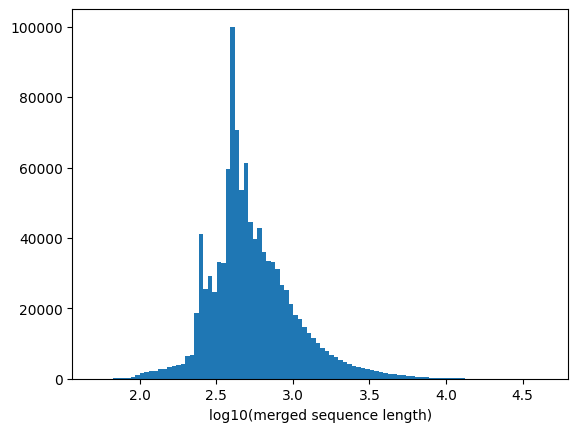

In [53]:
len_seq = ad_chip.var['end'] - ad_chip.var['start']
print(np.min(len_seq), np.max(len_seq))
plt.hist(np.log10(len_seq), bins=100);
plt.xlabel("log10(merged sequence length)");
# print(np.log10(1344*2))
# plt.vlines(np.log10(1344*2),0, 100000, colors='red');

In [42]:
chip_summary = pd.DataFrame(ad_chip.to_df().sum(axis=0)/ad_chip.shape[0], columns=['perc_positive_sample'])
seq_len_bins = pd.cut(np.log10(len_seq), bins=10)
chip_summary['_log_seq_len_bin'] = seq_len_bins

In [43]:
chip_summary[:5]

,perc_positive_sample,_log_seq_len_bin
chr1:9825-10444,0.005760,"(2.591, 2.885]"
chr1:30604-31108,0.001152,"(2.591, 2.885]"
chr1:51978-52358,0.000576,"(2.296, 2.591]"
chr1:83547-84237,0.000576,"(2.591, 2.885]"
chr1:90978-91321,0.000576,"(2.296, 2.591]"


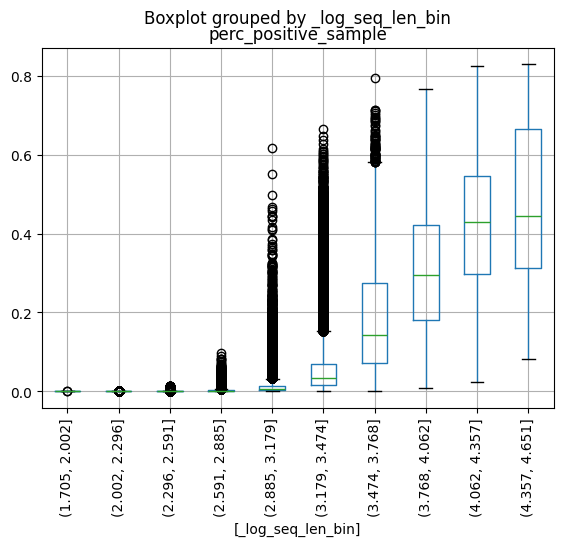

In [47]:
ax = chip_summary.boxplot(by='_log_seq_len_bin');
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);


4 76115


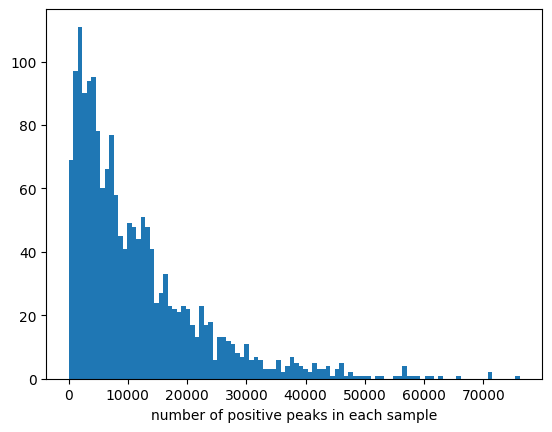

In [61]:
sample_expression = np.array(ad_chip.X.sum(axis=1)).flatten()      
print(np.min(sample_expression), np.max(sample_expression))
plt.hist(sample_expression, bins=100);
plt.xlabel("number of positive peaks in each sample");

In [65]:
## filter out samples with <= 500 peaks 
ad_chip = ad_chip[sample_expression>500, :]         ## ~ 0.02 quantile 
print(ad_chip.shape)

(1701, 1086877)


0 1432


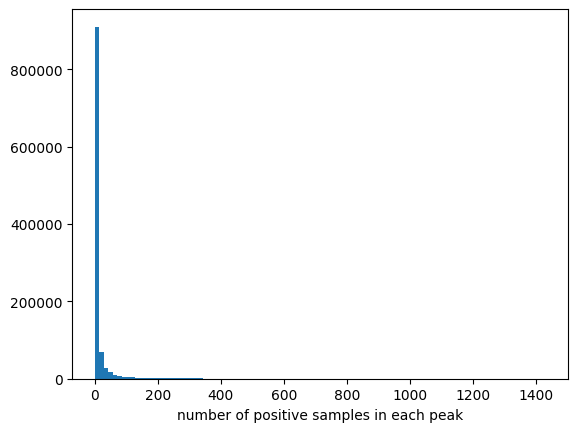

In [66]:
peak_expression = np.array(ad_chip.X.sum(axis=0)).flatten()
print(np.min(peak_expression), np.max(peak_expression))
plt.hist(peak_expression, bins=100);
plt.xlabel("number of positive samples in each peak");

In [68]:
ad_chip = ad_chip[:,peak_expression>0]         ## ~ 0.02 quantile 
print(ad_chip.shape)

(1701, 1086397)


In [69]:
ad_chip.write_h5ad(f"{Target_dir}/ad_chip_filtered.h5ad")

## write chip sequences to fasta

In [5]:
def seq_pos_2_fasta(seqs:pd.DataFrame, fasta_ref=f"{BASE_DIR}/genomes/hg38/hg38.fa", save_path=""):
    '''
    seqs: pd dataframe of columns ["chrom", 'start', 'stop'] 
    '''
    a = pybedtools.BedTool.from_dataframe(seqs)
    a = a.sequence(fi=fasta_ref)
    a.save_seqs(save_path)    
    return

In [6]:
ad_chip = sc.read_h5ad(f"{Target_dir}/ad_chip_filtered.h5ad")
ad_chip

AnnData object with n_obs × n_vars = 1701 × 1086397
    obs: 'Accession', 'Target of assay', 'Biosample term name', 'Biosample classification', 'Assay title', 'bed narrowPeak', 'process version'
    var: 'chr', 'start', 'end'

In [7]:
chip_regions = pd.DataFrame(index = ad_chip.var.index, columns=["chrom", "start", "stop"])
chip_regions['chrom'] = chip_regions.index.str.split(":").str[0]
chip_regions['start'] = chip_regions.index.str.split(":").str[1].str.split("-").str[0]
chip_regions['stop'] = chip_regions.index.str.split(":").str[1].str.split("-").str[1]
chip_regions[:5]

,chrom,start,stop
chr1:9825-10444,chr1,9825,10444
chr1:30604-31108,chr1,30604,31108
chr1:51978-52358,chr1,51978,52358
chr1:83547-84237,chr1,83547,84237
chr1:90978-91321,chr1,90978,91321


In [8]:
seq_pos_2_fasta(seqs=chip_regions, 
                fasta_ref=f"{BASE_DIR}/genomes/hg38/hg38.fa", 
                save_path=f"{Target_dir}/chip_seqs.fasta")